In [118]:
# https://www.kaggle.com/code/robikscube/time-series-forecasting-with-machine-learning-yt

In [119]:
# https://www.kaggle.com/competitions/godaddy-microbusiness-density-forecasting/discussion/372780

In [ ]:
# https://towardsdatascience.com/interpreting-acf-and-pacf-plots-for-time-series-forecasting-af0d6db4061c
# https://www.analyticsvidhya.com/blog/2019/12/6-powerful-feature-engineering-techniques-time-series/

In [120]:
import warnings
warnings.simplefilter("ignore")

In [121]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load data

In [122]:
df = pd.read_csv('PJME_hourly.csv')

In [123]:
df.sample(5)

,Datetime,PJME_MW
10561,2003-10-17 05:00:00,22136.0
50999,2007-03-07 12:00:00,42010.0
68564,2009-03-06 13:00:00,32992.0
136126,2017-06-21 23:00:00,34551.0
99117,2013-09-10 22:00:00,43948.0


In [124]:
df.shape

(145366, 2)

# 2. Check data quality

data type

In [125]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145366 entries, 0 to 145365
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Datetime  145366 non-null  object 
 1   PJME_MW   145366 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.2+ MB


In [126]:
df['Datetime'] = pd.to_datetime(df['Datetime'])

unique value

In [127]:
df.shape

(145366, 2)

In [128]:
for i in df.columns:
    print('Columns name: ', i)
    print('Unique value: ', df[i].unique())
    print('Count unique value: ', df[i].nunique())
    print('-'*10)

Columns name:  Datetime
Unique value:  <DatetimeArray>
['2002-12-31 01:00:00', '2002-12-31 02:00:00', '2002-12-31 03:00:00',
 '2002-12-31 04:00:00', '2002-12-31 05:00:00', '2002-12-31 06:00:00',
 '2002-12-31 07:00:00', '2002-12-31 08:00:00', '2002-12-31 09:00:00',
 '2002-12-31 10:00:00',
 ...
 '2018-01-01 15:00:00', '2018-01-01 16:00:00', '2018-01-01 17:00:00',
 '2018-01-01 18:00:00', '2018-01-01 19:00:00', '2018-01-01 20:00:00',
 '2018-01-01 21:00:00', '2018-01-01 22:00:00', '2018-01-01 23:00:00',
 '2018-01-02 00:00:00']
Length: 145362, dtype: datetime64[ns]
Count unique value:  145362
----------
Columns name:  PJME_MW
Unique value:  [26498. 25147. 24574. ... 43663. 44343. 40164.]
Count unique value:  28441
----------


In [129]:
df[df.duplicated('Datetime', keep=False)]

,Datetime,PJME_MW
106584,2014-11-02 02:00:00,22935.0
106585,2014-11-02 02:00:00,23755.0
115368,2015-11-01 02:00:00,21567.0
115369,2015-11-01 02:00:00,21171.0
124008,2016-11-06 02:00:00,20795.0
124009,2016-11-06 02:00:00,21692.0
132816,2017-11-05 02:00:00,21236.0
132817,2017-11-05 02:00:00,20666.0


In [130]:
df = df.groupby('Datetime')['PJME_MW'].mean().reset_index()

In [131]:
df.rename(columns={'PJME_MW': 'PJME_MW'}, inplace=True)

In [132]:
df.shape

(145362, 2)

missing value

In [133]:
df.isnull().sum()

Datetime    0
PJME_MW     0
dtype: int64

zero value

In [134]:
(df == 0).sum()

Datetime    0
PJME_MW     0
dtype: int64

blank value

In [135]:
(df == '').sum()

Datetime    0
PJME_MW     0
dtype: int64

# 3. Exploratory data analysis (EDA)

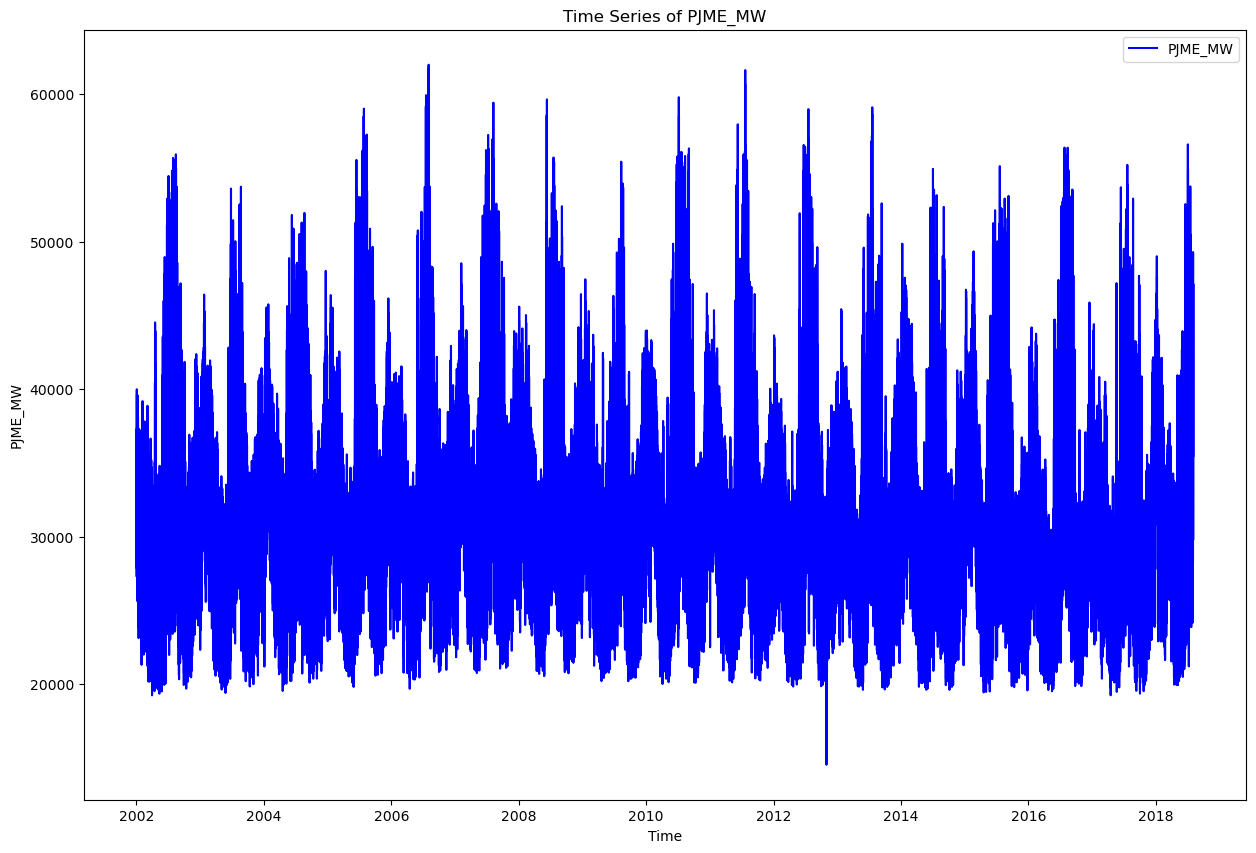

In [136]:
plt.figure(figsize=(15, 10))
plt.plot(df['Datetime'], df['PJME_MW'], label='PJME_MW', color='blue')
plt.xlabel('Time')
plt.ylabel('PJME_MW')
plt.legend()
plt.title('Time Series of PJME_MW')
plt.show()

In [137]:
from statsmodels.graphics.tsaplots import plot_acf


In [138]:
# Assuming 'Datetime' is the column with datetime and 'Target' is your series of interest
df.sort_values('Datetime', inplace=True)
df.set_index('Datetime', inplace=True)

In [ ]:
# lag_hours = [1, 24, 168, 720, 1440, 2160, 2880, 3600, 4320, 8640]

<Figure size 2000x700 with 0 Axes>

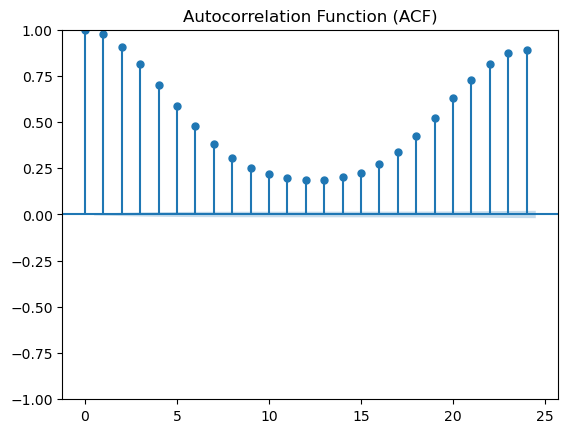

In [162]:
# Plot ACF
plt.figure(figsize=(20, 7))  # Set figure size for better readability
plot_acf(df['PJME_MW'], lags=24)  # Adjust the number of lags as needed
plt.title('Autocorrelation Function (ACF)')
plt.show()

<Figure size 2000x700 with 0 Axes>

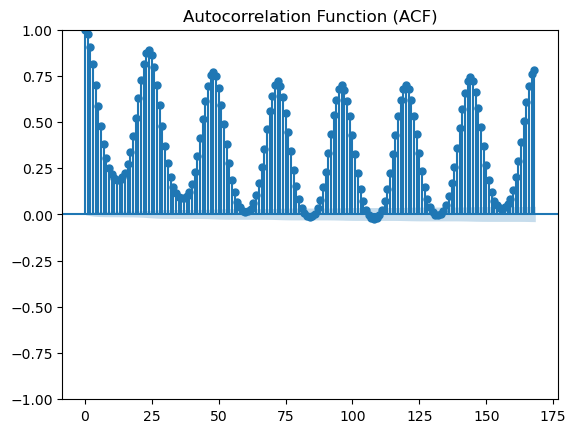

In [165]:
plt.figure(figsize=(20, 7))  # Set figure size for better readability
plot_acf(df['PJME_MW'], lags=168)  # Adjust the number of lags as needed
plt.title('Autocorrelation Function (ACF)')
plt.show()

<Figure size 2000x700 with 0 Axes>

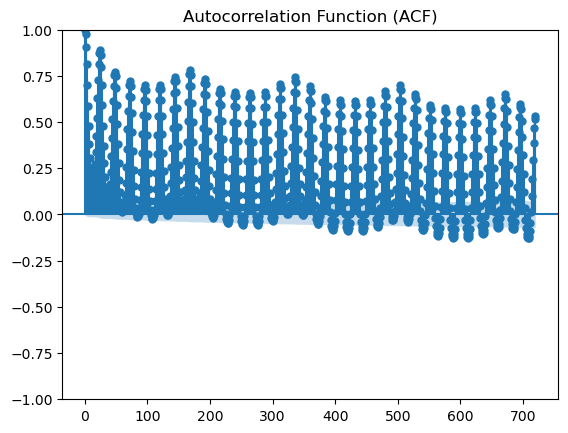

In [166]:
plt.figure(figsize=(20, 7))  # Set figure size for better readability
plot_acf(df['PJME_MW'], lags=720)  # Adjust the number of lags as needed
plt.title('Autocorrelation Function (ACF)')
plt.show()

<Figure size 2000x700 with 0 Axes>

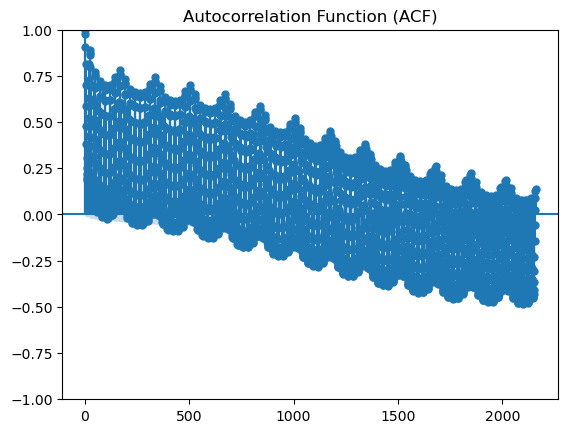

In [169]:
plt.figure(figsize=(20, 7))  # Set figure size for better readability
plot_acf(df['PJME_MW'], lags=2160)  # Adjust the number of lags as needed
plt.title('Autocorrelation Function (ACF)')
plt.show()

# lag_hours = [1, 24, 168, 720, 1440, 2160, 2880, 3600, 4320, 8640]

<Figure size 2000x700 with 0 Axes>

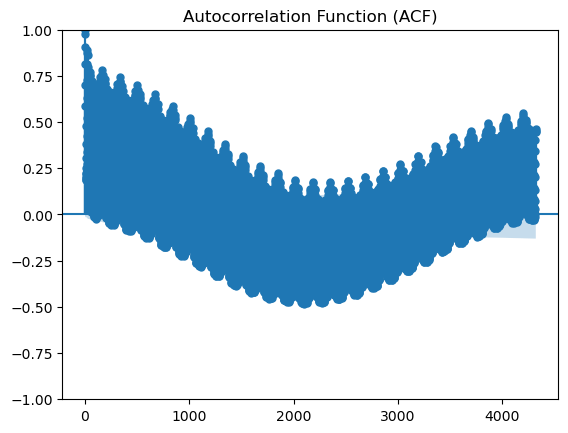

In [171]:
plt.figure(figsize=(20, 7))  # Set figure size for better readability
plot_acf(df['PJME_MW'], lags=4320)  # Adjust the number of lags as needed
plt.title('Autocorrelation Function (ACF)')
plt.show()

# lag_hours = [1, 24, 168, 720, 1440, 2160, 2880, 3600, 4320, 8640]

In [170]:
2160/24

90.0

In [167]:
720/24

30.0

In [159]:
2160/24

90.0

In [ ]:
**

# 3. Feature engineering

In [ ]:
# Datetime features

In [ ]:
df['hour'] = df['Datetime'].dt.hour
df['sin_hour'] = np.sin(2 * np.pi * df['Datetime'].dt.hour / 24)
df['cos_hour'] = np.cos(2 * np.pi * df['Datetime'].dt.hour / 24)

df['dayofweek'] = df['Datetime'].dt.dayofweek
df['sin_dayofweek'] = np.sin(2 * np.pi * df['Datetime'].dt.dayofweek / 7)
df['cos_dayofweek'] = np.cos(2 * np.pi * df['Datetime'].dt.dayofweek / 7)

df['quarter'] = df['Datetime'].dt.quarter
df['sin_quarter'] = np.sin(2 * np.pi * df['Datetime'].dt.quarter / 4)
df['cos_quarter'] = np.cos(2 * np.pi * df['Datetime'].dt.quarter / 4)

df['month'] = df['Datetime'].dt.month
df['sin_month'] = np.sin(2 * np.pi * df['Datetime'].dt.month / 12)
df['cos_month'] = np.cos(2 * np.pi * df['Datetime'].dt.month / 12)

min_year = df['Datetime'].dt.year.min()
num_unique_years = df['Datetime'].dt.year.nunique()
df['year'] = (df['Datetime'].dt.year)-min_year
df['sin_year'] = np.sin(2 * np.pi * df['year'] / num_unique_years)
df['cos_year'] = np.cos(2 * np.pi * df['year'] / num_unique_years)

df['dayofyear'] = df['Datetime'].dt.dayofyear
df['dayofmonth'] = df['Datetime'].dt.day
df['weekofyear'] = df['Datetime'].dt.isocalendar().week
df['weekofmonth'] = np.ceil(df['dayofmonth'] / 7).astype(int)
df['is_weekend'] = (df['Datetime'].dt.dayofweek >= 5).astype(int)
df['is_leap_year'] = df['Datetime'].dt.is_leap_year.astype(int)
df['is_month_start'] = df['Datetime'].dt.is_month_start.astype(int)
df['is_month_end'] = df['Datetime'].dt.is_month_end.astype(int)
df['is_year_start'] = df['Datetime'].dt.is_year_start.astype(int)
df['is_year_end'] = df['Datetime'].dt.is_year_end.astype(int)

In [ ]:
lag_hours = [1, 24, 168, 720, 1440, 2160, 2880, 3600, 4320]

In [ ]:
# Generate lag features for the 'Target' column
for lag in lag_hours:
    df[f'Target_lag_{lag}h'] = df['PJME_MW'].shift(periods=lag)
df.fillna(method='bfill', inplace=True)  # Backfill or another method could be used
# Reset index if you need 'Datetime' back as a column later
df.reset_index(inplace=True)

In [ ]:
df